In [1]:
from transformers import AutoModelForMaskedLM, TrainingArguments, Trainer, AutoTokenizer
import torch

# from lava import LavaModelSmall
# model = LavaModelSmall.from_lava_pretrained('roberta-base', 'facebook/bart-base')

from utils.datasets_config import get_dataset

dset = get_dataset('gigaword', 'facebook/bart-base')
print(dset)

tokenizer = AutoTokenizer.from_pretrained('facebook/bart-base')


from lava import LavaModel
model = LavaModel.from_pretrained('cestwc/lava-small-gigaword').cuda().eval()

Found cached dataset gigaword (/home/azureuser/.cache/huggingface/datasets/gigaword/default/1.2.0/ea83a8b819190acac5f2dae011fad51dccf269a0604ec5dd24795b64efb424b6)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at /home/azureuser/.cache/huggingface/datasets/gigaword/default/1.2.0/ea83a8b819190acac5f2dae011fad51dccf269a0604ec5dd24795b64efb424b6/cache-ec2f04cbc5a64a59.arrow
Loading cached processed dataset at /home/azureuser/.cache/huggingface/datasets/gigaword/default/1.2.0/ea83a8b819190acac5f2dae011fad51dccf269a0604ec5dd24795b64efb424b6/cache-f10e57b03c68e54b.arrow
Loading cached processed dataset at /home/azureuser/.cache/huggingface/datasets/gigaword/default/1.2.0/ea83a8b819190acac5f2dae011fad51dccf269a0604ec5dd24795b64efb424b6/cache-b8e4fbcfe3300933.arrow


Number of gigaword training examples: 3803957
Number of gigaword validation examples: 189651
Number of gigaword testing examples: 1951
DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels', 'input_texts', 'label_texts'],
        num_rows: 3803957
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels', 'input_texts', 'label_texts'],
        num_rows: 189651
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels', 'input_texts', 'label_texts'],
        num_rows: 1951
    })
})


You passed along `num_labels=3` with an incompatible id to label map: {'0': 'LABEL_0', '1': 'LABEL_1'}. The number of labels wil be overwritten to 2.


In [2]:
def collate(batch):
    batch = ({k: torch.nn.utils.rnn.pad_sequence([dic[k] for dic in batch], batch_first=True, padding_value=1) for k in batch[0]})
    batch['input_ids'][batch['input_ids'] == 2] = 0
    batch['attention_mask'] = (batch['input_ids'] != 1).long()
    batch['labels'][batch['labels']==1] = -100
#     batch['labels'] = torch.nn.functional.pad(batch['labels'], (0, batch['input_ids'].shape[1] - batch['labels'].shape[1], 0, 0), 'constant', 1)
    return batch

In [3]:
trainer = Trainer(
    model = model,
#     args = training_args,
    train_dataset = dset['train'].shuffle(1234),
    eval_dataset = dset['test'],
    data_collator = collate,
    # compute_metrics = lambda x: print(x),
    # callbacks = [EarlyStoppingCallback(early_stopping_patience=7)],
)


Loading cached shuffled indices for dataset at /home/azureuser/.cache/huggingface/datasets/gigaword/default/1.2.0/ea83a8b819190acac5f2dae011fad51dccf269a0604ec5dd24795b64efb424b6/cache-b72e92e25248f7d5.arrow


In [4]:
# trainer._load_from_checkpoint('lava-ce/checkpoint-2000000')

In [5]:
# trainer.evaluate()

In [6]:
d = next(iter(dset['train'].shard(300, 1).shuffle()))
decoder_input_ids = (d['labels'] == 1).long()

Loading cached shuffled indices for dataset at /home/azureuser/.cache/huggingface/datasets/gigaword/default/1.2.0/ea83a8b819190acac5f2dae011fad51dccf269a0604ec5dd24795b64efb424b6/cache-92e797154ba25e06.arrow


In [7]:
o = model(
    input_ids = d['input_ids'].cuda().unsqueeze(0),
    attention_mask = d['attention_mask'].cuda().unsqueeze(0),
    generate = True
)

In [8]:
d

{'input_ids': tensor([    0,   397, 17419, 10409,    34,  4768,   690,    14,   169,   858,
          4533,  6071,    40,    28,  1088,    11,     5, 10408, 16705,  2937,
          2931,  1437,  1437,   511, 18898,  6116,    59,     5,  5955,  1437,
           579,   499,    23,     5,   950,  1437,  1437,     2]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 'labels': tensor([    0, 33557,  9118,   708,     7,  1331,  4533,  6071,     2])}

In [9]:
o.logits.argmax(2)

tensor([[    0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0, 33557,
             0,  4533,  6071,  8762,     2]], device='cuda:0')

In [10]:
tokenizer.decode(o.logits.argmax(2).tolist()[0], skip_special_tokens=False)


'<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>united<s> rooney rumors</s>'

In [11]:
print(tokenizer.decode(d['input_ids'], skip_special_tokens=True))
print()
print(tokenizer.decode(d['labels'], skip_special_tokens=True))

manchester united has dismissed reports that wayne rooney will be sold in the january transfer window   following rampant speculation about the striker  s future at the club  

united denies plans to sell rooney


In [12]:
scores = model.decoder(input_ids = d['input_ids'].cuda().unsqueeze(0), decoder_input_ids = 50264 * torch.ones_like(d['input_ids']).cuda().unsqueeze(0)).end_logits
scores

tensor([[-3.6925, -5.5269, -5.5113, -4.0515, -4.1184, -0.6773, -0.7303,  1.1776,
          2.8540,  3.8152,  4.3044,  4.8758,  5.3149,  5.2120,  4.9470,  5.3463,
          5.5964,  5.7420,  5.8916,  5.9187,  5.7672,  5.7794,  5.6632,  5.5926,
          5.5555,  5.5234,  5.5260,  5.6884,  5.4674,  5.5135,  5.5757,  5.4896,
          5.5796,  5.6184,  5.5918,  5.5302,  5.6353,  5.6733]],
       device='cuda:0', grad_fn=<CloneBackward0>)

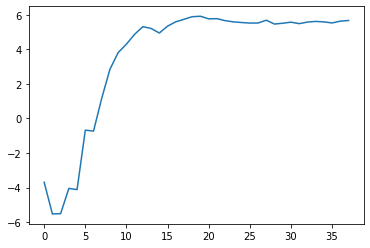

In [13]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(scores.tolist()[0])

In [14]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 181,421,145 trainable parameters


In [15]:
model.decoder(input_ids = d['input_ids'].cuda().unsqueeze(0), decoder_input_ids = 50264 * torch.ones_like(d['input_ids']).cuda().unsqueeze(0)).end_logits

tensor([[-3.6925, -5.5269, -5.5113, -4.0515, -4.1184, -0.6773, -0.7303,  1.1776,
          2.8540,  3.8152,  4.3044,  4.8758,  5.3149,  5.2120,  4.9470,  5.3463,
          5.5964,  5.7420,  5.8916,  5.9187,  5.7672,  5.7794,  5.6632,  5.5926,
          5.5555,  5.5234,  5.5260,  5.6884,  5.4674,  5.5135,  5.5757,  5.4896,
          5.5796,  5.6184,  5.5918,  5.5302,  5.6353,  5.6733]],
       device='cuda:0', grad_fn=<CloneBackward0>)